# E-commerce Sales Analysis Pipeline
**Objective:** Clean and analyze a large-scale retail dataset to extract business KPIs.<br>
**Author:** [Rafael Campos Andrés]<br>
**Date:** January 2026

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

In [50]:
# Visual style
sns.set_theme(style="whitegrid", palette="inferno")
plt.rcParams["figure.figsize"] = (12, 6)

In [51]:
# Loading raw data
base_dir = Path.cwd().parent
data_path = base_dir / "data" / "raw_sales_data.csv"
if data_path.exists():
    try:
        df = pd.read_csv(data_path)
        df['date'] = pd.to_datetime(df['date'])
        print(f"File: {data_path} uploaded succesfully")
    except:
        print(f"File: {data_path} is empty or could not be found")
else:
    print(f"File: {data_path} could not be found")

File: c:\Users\USUARIO\Desktop\GITHUB\E-commerce-Data-Pipeline-Analysis\data\raw_sales_data.csv uploaded succesfully


In [52]:
# Cleaning category names
df['category'] = df['category'].str.replace('_', '').str.strip().str.capitalize()
condition = df['category'].str.contains('Elec', na=False)
df['category'] = np.where(condition, 'Electronics', df['category'])
print(df.sample(5))

      order_id       date     product     category  unit_price  quantity  \
3818      4818 2025-09-29      Laptop  Electronics  237.174855         1   
4579      5579 2025-06-16      Laptop  Electronics  173.663689         1   
3414      4414 2025-11-11  Smartphone       Office  832.273792         2   
6788      7788 2025-03-19      Laptop  Accessories  805.984712         1   
4305      5305 2025-07-21  Headphones  Electronics  767.391551         1   

         customer_email      city  
3818                NaN   Sevilla  
4579                NaN   Sevilla  
3414                NaN    Bilbao  
6788                NaN    Bilbao  
4305  admin@outlook.com  Valencia  


In [53]:
# Fill na
df['customer_email'] = df['customer_email'].fillna('user@gmail.com')

df['unit_price'] = df.groupby('product')['unit_price'].transform('mean')
print(df.sample(5))

      order_id       date     product     category  unit_price  quantity  \
3777      4777 2025-01-21      Laptop  Accessories  602.841974         5   
2947      3947 2025-10-11      Laptop  Electronics  602.841974         1   
4981      5981 2025-09-08  Smartphone  Accessories  622.349579         1   
6437      7437 2025-09-03     Monitor  Electronics  609.660984         1   
3977      4977 2025-01-08    Keyboard  Electronics  619.523999         5   

         customer_email       city  
3777  admin@outlook.com     Madrid  
2947  admin@outlook.com    Sevilla  
4981     user@gmail.com  Barcelona  
6437  admin@outlook.com     Bilbao  
3977  admin@outlook.com     Bilbao  


In [54]:
# Detection and correction of anomalies
def get_anomalies(df, c):
    max_normal_value = df[c].sum() / 100 # Over 1% of total
    anomalies_ids = df[df[c] > max_normal_value].index.tolist()
    return anomalies_ids

attend_columns = ['unit_price', 'quantity']

df_clean = df.copy()

for c in attend_columns:
    anomalies = get_anomalies(df_clean, c)
    if anomalies:
        print(f'Anomalies found in {c}. Indexes: {anomalies}')
        try:
            df_clean = df_clean.drop(index=anomalies, errors='ignore')
        except:
            print('Error removing anomalies')
        else:
            print('Anomalies successfully removed')
    else:
        print(f'No anomalies in {c}')

df = df_clean.copy()


No anomalies in unit_price
No anomalies in quantity


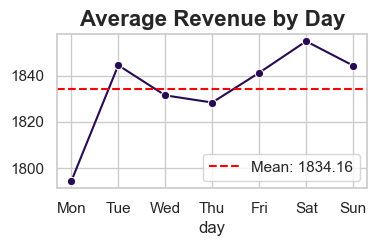

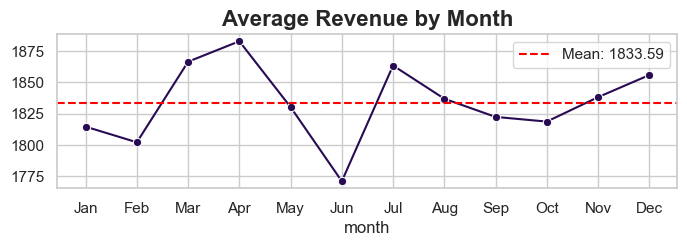

In [61]:
# Profit analysis
df['revenue'] = df['quantity'] * df['unit_price']

days_map = {
    0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 
    4: 'Fri', 5: 'Sat', 6: 'Sun'
}
months_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
temp = df[['date', 'revenue']].copy()
temp['day'] = temp['date'].dt.day_of_week
temp['month'] = temp['date'].dt.month
day_of_week_analysis = temp.groupby('day')['revenue'].mean().sort_index()
month_analysis = temp.groupby('month')['revenue'].mean().sort_index()
day_of_week_analysis.index = day_of_week_analysis.index.map(days_map)
month_analysis.index = month_analysis.index.map(months_map)

mean_week = day_of_week_analysis.mean()
mean_year = month_analysis.mean()

plt.figure(figsize=(4, 2))
sns.lineplot(x=day_of_week_analysis.index, y=day_of_week_analysis.values, marker='o')
plt.axhline(mean_week, color='red', linestyle='--', label=f'Mean: {mean_week:.2f}')
plt.title('Average Revenue by Day', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

plt.figure(figsize=(8, 2))
sns.lineplot(x=month_analysis.index, y=month_analysis.values, marker='o')
plt.axhline(mean_year, color='red', linestyle='--', label=f'Mean: {mean_year:.2f}')
plt.title('Average Revenue by Month', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

            units_sold  mean_price  real_millions  expected_millions  \
product                                                                
Keyboard          6171  619.523999       3.823083           3.823083   
Smartphone        6138  622.349579       3.819982           3.819982   
Monitor           5979  609.660984       3.645163           3.645163   
Headphones        5886  599.512240       3.528729           3.528729   
Laptop            5843  602.841974       3.522406           3.522406   

            reconciliation  
product                     
Keyboard               0.0  
Smartphone             0.0  
Monitor                0.0  
Headphones             0.0  
Laptop                 0.0  


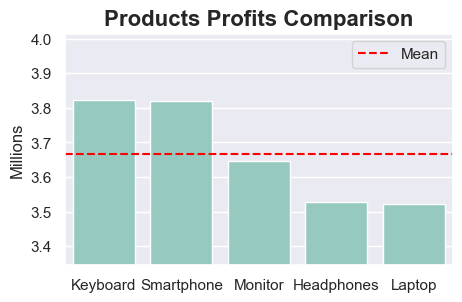

In [95]:
# Analyze profits per product
product_analysis = df.copy()
product_analysis = product_analysis.groupby('product').agg(
    units_sold = ('quantity', 'sum'),
    mean_price = ('unit_price', 'mean'),
    real_millions = ('revenue', 'sum')
).sort_values(by='real_millions', ascending=False)
product_analysis['expected_millions'] = (product_analysis['mean_price'] * product_analysis['units_sold']) / 1000000
product_analysis['real_millions'] = product_analysis['real_millions'] / 1000000
product_analysis['reconciliation'] = product_analysis['real_millions'] - product_analysis['expected_millions']
print(product_analysis)

sns.set_theme(palette="Set3")
plt.figure(figsize=(5, 3))
plt.title('Products Profits Comparison', fontsize=16, fontweight='bold')
sns.barplot(data=product_analysis, x='product', y='real_millions').set(xlabel=None, ylabel="Millions")
plt.axhline(y=product_analysis['real_millions'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()

min_val = product_analysis['real_millions'].min() * 0.95 
max_val = product_analysis['real_millions'].max() * 1.05
plt.ylim(min_val, max_val)

plt.show()

                       sales    profit
city      category                    
Barcelona Accessories    588  1.054040
          Electronics   1011  1.861733
          Office         384  0.722253
Bilbao    Accessories    556  0.988482
          Electronics    999  1.852361
          Office         390  0.751432
Madrid    Accessories    602  1.102158
          Electronics   1035  1.860150
          Office         379  0.706907
Sevilla   Accessories    598  1.087135
          Electronics   1049  1.948799
          Office         447  0.840445
Valencia  Accessories    580  1.064806
          Electronics    998  1.810359
          Office         384  0.688301


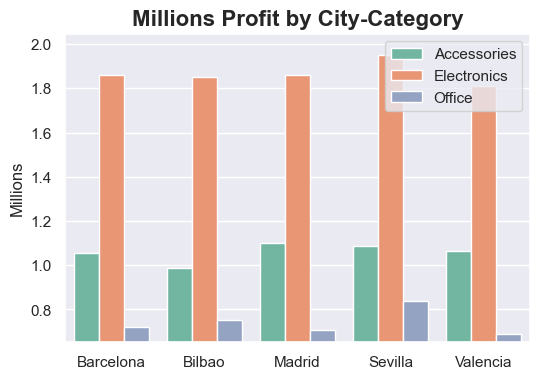

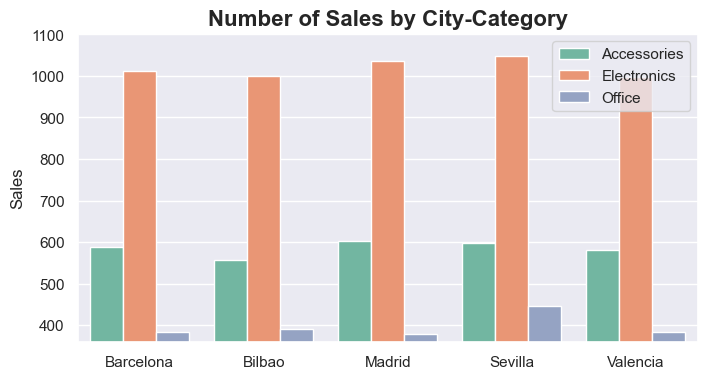

In [96]:
# Compare sales quantity and revenue by category between citys
city_analysis = df.copy()
city_analysis = city_analysis.groupby(['city', 'category']).agg(
    sales = ('order_id', 'count'),
    profit = ('revenue', 'sum')
)
city_analysis['profit'] = (city_analysis['profit'] / 1000000)
print(city_analysis)

sns.set_theme(palette="Set2")
plt.figure(figsize=(6, 4))
sns.barplot(data=city_analysis, x='city', y='profit', hue='category').set(xlabel=None, ylabel='Millions')

min_val = city_analysis['profit'].min() * 0.95
max_val = city_analysis['profit'].max() * 1.05
plt.ylim(min_val, max_val)
plt.title('Millions Profit by City-Category', fontsize=16, fontweight='bold')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=city_analysis, x='city', y='sales', hue='category').set(xlabel=None, ylabel='Sales')

min_val = city_analysis['sales'].min() * 0.95
max_val = city_analysis['sales'].max() * 1.05
plt.ylim(min_val, max_val)
plt.title('Number of Sales by City-Category', fontsize=16, fontweight='bold')
plt.legend(loc='upper right')
plt.show()

           orders         spent
user_type                      
user         5013  9.201025e+06
client       2523  4.580395e+06
admin        2464  4.557943e+06


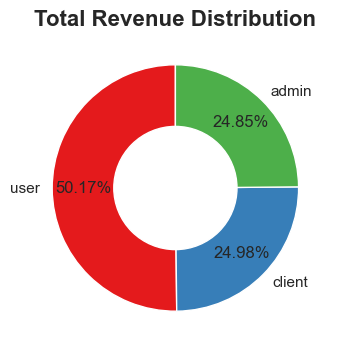

In [97]:
# Customer revenue distribution
customer_analysis = df.copy()

conditions = [
    customer_analysis['customer_email'].str.startswith('client'),
    customer_analysis['customer_email'].str.startswith('user'),
    customer_analysis['customer_email'].str.contains('admin')
]

types = ['client', 'user', 'admin']

customer_analysis['user_type'] = np.select(conditions, types, default='user')
customer_analysis = customer_analysis.groupby('user_type').agg(
    orders = ("order_id", "count"),
    spent = ("revenue", "sum")
).sort_values(by="spent", ascending=False)
print(customer_analysis)

sns.set_theme(palette="Set1")
plt.figure(figsize=(4, 4))
plt.pie(customer_analysis['spent'], 
        labels=customer_analysis.index, 
        autopct='%1.2f%%',
        pctdistance=0.75,
        startangle=90
        )
plt.title("Total Revenue Distribution", fontsize=16, fontweight='bold')

centre_circle = plt.Circle((0,0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

In [59]:
# Load final dataframe
base_path = Path.cwd().parent
output_dir = base_path / "outputs"
file_path = output_dir / "cleaned_sales_data.csv"
output_dir.mkdir(parents=True, exist_ok=True)
df.to_csv(file_path, index=False)

print(f"File was successfully loaded in relative route: {file_path}")

File was successfully loaded in relative route: c:\Users\USUARIO\Desktop\GITHUB\E-commerce-Data-Pipeline-Analysis\outputs\cleaned_sales_data.csv


In [60]:
# Executive Summary
total_rev = df['revenue'].sum()
avg_order = df['revenue'].mean()
initial_rows = df['order_id'].count()
clean_rows = len(df)
efficiency = (clean_rows / initial_rows) * 100

print("="*30)
print("🚀 EXECUTIVE SALES SUMMARY")
print("="*30)
print(f"💰 Total Revenue:      ${total_rev:,.2f}")
print(f"🛒 Avg. Order Value:   ${avg_order:,.2f}")
print(f"🧹 Data Integrity:     {efficiency:.1f}% ({clean_rows} rows)")

🚀 EXECUTIVE SALES SUMMARY
💰 Total Revenue:      $18,339,362.04
🛒 Avg. Order Value:   $1,833.94
🧹 Data Integrity:     100.0% (10000 rows)
